In [28]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
import os
from IPython.core.display import display,HTML

signals = pd.read_csv('../data/retrotech/signals.csv')

seed=8675309
random.seed(seed)
np.random.seed(seed)

NUM_SESSIONS=500000 # how many sessions to generate?

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Gather queries occuring above a certain threshold

In [29]:
MIN_QUERY_EVENTS=100

queries = signals[signals['type'] == 'query']
popular_queries = queries.groupby('target').count() \
                         .rename(columns={'query_id': 'query_count'}) \
                         .sort_values('query_count', ascending=False)
popular_queries = popular_queries[popular_queries['query_count'] > MIN_QUERY_EVENTS].index.to_list()
pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]
query_events = pop_query_events[['query_id', 'target']].rename(columns={'target': 'query'})

# Cleanup by lowercasing
# This step has its pros and cons. We might miss some info that case gives us, but it also
# aggregates more signal per query
query_events['query'] = query_events['query'].apply(lambda q: q.lower())
query_events

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,query_id,query
0,u2_0_1,nook
1,u2_1_2,rca
2,u3_0_1,macbook
3,u4_0_1,tv antenna
6,u7_0_1,camcorder
...,...,...
725452,u744327_0_1,dre beats
725453,u744328_0_1,sirius radio
725455,u744330_0_1,usb drive
725456,u744331_0_1,iphone 4s


# Join click events with corresponding queries into one table

In [30]:
clicks = signals[signals['type'] == 'click']
click_events = clicks[['query_id', 'target']].rename(columns={'target': 'clicked_doc_id'})
clicks_per_query = query_events.merge(click_events, 
                                      on='query_id', 
                                      how='left')
clicks_per_query['clicked_doc_id'] = clicks_per_query['clicked_doc_id'].fillna(0)
# clicks_per_query.groupby('query').count().sort_values('query_id', ascending=False)

clicks_per_query

,query_id,query,clicked_doc_id
0,u2_0_1,nook,9781400532650
1,u2_1_2,rca,883393001119
2,u3_0_1,macbook,885909464036
3,u4_0_1,tv antenna,079000334835
4,u7_0_1,camcorder,027242821866
...,...,...,...
488539,u744327_0_1,dre beats,848447000135
488540,u744328_0_1,sirius radio,884720004032
488541,u744330_0_1,usb drive,718037770604
488542,u744331_0_1,iphone 4s,885909538027


# Compute a CTR for each query/doc pair

0.15889705213356384
0.10964912280701754
0.07842453816660858
0.059931506849315065


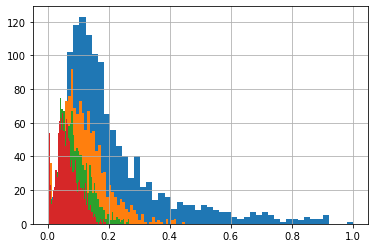

In [31]:
# tot number of queries (denom if CTR)
denominator = query_events.groupby('query').count().rename(columns={'query_id': 'tot_query_count'})

# click counts per doc in query
click_thru_rate = clicks_per_query.groupby(['query', 'clicked_doc_id']).count().rename(columns={'query_id':'click_count'}).reset_index()
click_thru_rate = click_thru_rate.merge(denominator, on='query', how='left')

click_thru_rate['ctr'] = click_thru_rate['click_count'] / click_thru_rate['tot_query_count']
click_thru_rate = click_thru_rate.sort_values(['query', 'ctr'], ascending=[True, False])

# Get rid of doc_id 0, which is all the queries with no clicks
# We treat these as a canonical ranking from the source system, assume it's relatively
# highly tuned and the source CTRs are pretty reasonably close to actual relevance ranking
# in the source system. Of course this is a dubious assumption in a real search system, 
# but for our purposes - to synthesize reasonable looking search sessions - it will serve
canonical_rankings = click_thru_rate[click_thru_rate['clicked_doc_id'] != 0].reset_index()


# Just for display and sanity checking
print(canonical_rankings.groupby('query').nth(0)['ctr'].median())
canonical_rankings.groupby('query').nth(0)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(1)['ctr'].median())
canonical_rankings.groupby('query').nth(1)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(2)['ctr'].median())
canonical_rankings.groupby('query').nth(2)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(3)['ctr'].median())
canonical_rankings.groupby('query').nth(3)['ctr'].hist(bins=50)

# Compute stats of each CTR position

What's the mean, median, std deviaton, etc of CTR in each position? This lets us synthesize sessions assuming the above average or below average CTR is an indication of above or below average relevance

In [32]:
canonical_rankings['rank'] = canonical_rankings.groupby('query').cumcount()


max_depth = canonical_rankings['rank'].max()
for i in range(0, max_depth):
    idxs = canonical_rankings[canonical_rankings['rank'] == i].index
   
    # Mean based statistics
    canonical_rankings.loc[idxs, 'posn_ctr_mean'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mean()
    canonical_rankings.loc[idxs, 'posn_ctr_std'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].std()
 
    # Median based statistics (less outlier prone)
    canonical_rankings.loc[idxs, 'posn_ctr_median'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].median()
    canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()

canonical_rankings['ctr_std_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_mean']) / canonical_rankings['posn_ctr_std']
canonical_rankings['ctr_mod_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_median']) / canonical_rankings['posn_ctr_mad']

canonical_rankings[canonical_rankings['query'] == 'dryer'].head(20)

,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
15580,15844,dryer,12505451713,20,246,0.081301,0,0.215521,0.172469,0.158897,0.124872,-0.778227,-0.621404
15581,15893,dryer,883929085118,18,246,0.073171,1,0.121488,0.070496,0.109649,0.054231,-0.685393,-0.672647
15582,15887,dryer,883049066905,16,246,0.065041,2,0.087093,0.048757,0.078425,0.038821,-0.452290,-0.344763
15583,15854,dryer,36172950027,13,246,0.052846,3,0.065306,0.036182,0.059932,0.028924,-0.344385,-0.244987
15584,15870,dryer,74108056764,13,246,0.052846,4,0.051849,0.030129,0.048343,0.024117,0.033090,0.186711
15585,15872,dryer,77283045400,13,246,0.052846,5,0.041020,0.024764,0.039578,0.019993,0.477524,0.663618
15586,15883,dryer,783722274422,13,246,0.052846,6,0.031860,0.019346,0.031660,0.015932,1.084741,1.329765
15587,15880,dryer,665331101927,11,246,0.044715,7,0.026049,0.016632,0.025751,0.013968,1.122345,1.357717
15588,15848,dryer,14381196320,9,246,0.036585,8,0.021772,0.014593,0.020859,0.012446,1.015130,1.263529
15589,15871,dryer,74108096487,9,246,0.036585,9,0.018520,0.012575,0.017204,0.010934,1.436546,1.772473


# Create a single search session

Given statistics on CTR, assume the search engine returns a shuffled list of results, and recompute likely CTR for each position. Then randomly select whether there was a click

In [33]:
# Given query, shuffle 
import random
def synthesize_session(query, sess_id):
    canonical = canonical_rankings[canonical_rankings['query'] == query]
    if (len(canonical) == 0):
        return []
    l = list(range(0,min(20,canonical['rank'].max())))
    random.shuffle(l)
    search_with_hits = []
    for dest_rank, source_rank in enumerate(l):
        dest_median_ctr = canonical[canonical['rank'] == dest_rank]['posn_ctr_median'].to_list()[0]
        dest_mad_ctr = canonical[canonical['rank'] == dest_rank]['posn_ctr_mad'].to_list()[0]
        
        
        doc_id = canonical[canonical['rank'] == source_rank]['clicked_doc_id'].to_list()[0]
        
        # Get modified z-score when in it's in its ideal rank
        source_ctr_mod_zscore = canonical[canonical['rank'] == source_rank]['ctr_mod_z_score'].to_list()[0]
        source_ctr = canonical[canonical['rank'] == source_rank]['ctr'].to_list()[0]
        
        # Translate CTR to dest position using source zscore
        new_ctr = (source_ctr_mod_zscore * dest_mad_ctr) + dest_median_ctr
        
        click = random.random()
        if click <= new_ctr:
            click = True
        else:
            click = False
        
        search_with_hits.append(({"query": query,
                                  "sess_id": sess_id,
                                  "source_rank": source_rank, 
                                  "new_ctr": new_ctr, 
                                  "source_ctr_mod_zscore": source_ctr_mod_zscore, 
                                  "source_ctr": source_ctr, 
                                  "dest_mad_ctr": dest_mad_ctr, 
                                  "dest_median_ctr": dest_median_ctr, 
                                  "was_clicked": click,
                                  "doc_id": doc_id}))
    return search_with_hits

# Randomly sample source signals, generate new sessions

In [34]:
all_sessions = []
for sess_id in range(0, NUM_SESSIONS):
    query = queries.sample()['target'].to_list()
    if (len(query) == 1 and len(canonical_rankings[canonical_rankings['query'] == query[0]]) > 0):
        query=query[0].lower()

        all_sessions.extend(synthesize_session(query, sess_id))

In [37]:
all_sessions = pd.DataFrame(all_sessions).sort_values('query')

In [39]:
#all_sessions[all_sessions['query'] == 'iphone']

,query,sess_id,source_rank,new_ctr,source_ctr_mod_zscore,source_ctr,dest_mad_ctr,dest_median_ctr,was_clicked,doc_id
4293,iphone,444,19,0.071529,1.598137,0.010736,0.019993,0.039578,False,885909394500
4292,iphone,444,14,0.067441,0.791889,0.012326,0.024117,0.048343,False,97855069917
4291,iphone,444,15,0.089734,1.030359,0.012326,0.028924,0.059932,False,885909510344
12228,iphone,1296,3,0.003467,-0.546134,0.044135,0.005619,0.006536,False,885909459858
17463,iphone,1874,5,0.016000,-0.110143,0.037376,0.010934,0.017204,False,885909397723
...,...,...,...,...,...,...,...,...,...,...
41768,iphone,4501,1,0.001333,-0.819463,0.065209,0.005005,0.005435,False,885909394494
41769,iphone,4501,12,0.008193,0.688265,0.014712,0.004453,0.005128,False,885909538027
39115,iphone,4248,19,0.029626,1.598137,0.010736,0.009929,0.013758,False,885909394500
41770,iphone,4501,0,0.002638,-0.600616,0.083897,0.004017,0.005051,False,843404064434
